In [2]:
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import InformerConfig, InformerModel, InformerForPrediction, AutoformerConfig, AutoformerForPrediction
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Initializing an Informer configuration with 12 time steps for prediction
configuration = InformerConfig(prediction_length=1, context_length=24, num_time_features=6, lags_sequence = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
)

model = InformerForPrediction(configuration)

In [4]:
print(configuration.num_time_features+configuration.num_dynamic_real_features)

6


In [5]:
print(configuration.num_time_features)

6


In [6]:
configuration.context_length

24

In [7]:
configuration.prediction_length

1

In [8]:
print(configuration)

InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 24,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.05,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 32,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_re

In [9]:
device = torch.device("cpu")
device

device(type='cpu')

In [10]:
data = pd.read_csv("full.csv")
target_column = 'PRICE'  # Replace with the actual target column name

In [11]:
data.keys()

Index(['TIME', 'PRICE'], dtype='object')

In [12]:
print(data)

                  TIME  PRICE
0     01-01-2017 00:00  22.11
1     01-01-2017 01:00  21.30
2     01-01-2017 02:00  21.00
3     01-01-2017 03:00  20.56
4     01-01-2017 04:00  20.62
...                ...    ...
8755  31-12-2017 19:00  51.80
8756  31-12-2017 20:00  46.64
8757  31-12-2017 21:00  41.45
8758  31-12-2017 22:00  41.49
8759  31-12-2017 23:00  31.42

[8760 rows x 2 columns]


In [13]:
# Convert 'TIME' column to datetime
data['TIME'] = pd.to_datetime(data['TIME'], dayfirst=True)

In [14]:
# Sort the data based on time
data = data.sort_values(by='TIME')

In [15]:
data.shape

(8760, 2)

In [16]:
def create_time_features(data):
    # Extract relevant temporal information
    data['hour'] = data['TIME'].dt.hour
    data['day_of_week'] = data['TIME'].dt.dayofweek
    data['month'] = data['TIME'].dt.month
    data['day'] = data['TIME'].dt.day
    data['year'] = data['TIME'].dt.year

    # Add is_weekend feature
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

    # Drop the original timestamp and PRICE columns
    data = data.drop(columns=['TIME', 'PRICE'])

    return data.values


# Assuming 'data' is your DataFrame
past_time_features = create_time_features(data)


In [17]:
past_time_features.shape

(8760, 6)

In [18]:
# Extract features and target
features = data['PRICE'].values

In [19]:
features.shape

(8760,)

In [20]:
# Split the data into train and validation sets
train, val = train_test_split(features, test_size=0.2, shuffle=False)

In [21]:
train.shape

(7008,)

In [22]:
val.shape[0]

1752

In [23]:
time_train = past_time_features[:train.shape[0]]
time_val = past_time_features[train.shape[0]:]

In [24]:
time_train

array([[   0,    6,    1,    1, 2017,    1],
       [   1,    6,    1,    1, 2017,    1],
       [   2,    6,    1,    1, 2017,    1],
       ...,
       [  21,    3,   10,   19, 2017,    0],
       [  22,    3,   10,   19, 2017,    0],
       [  23,    3,   10,   19, 2017,    0]])

In [25]:
time_train.shape

(7008, 6)

In [26]:
time_val.shape

(1752, 6)

In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, price, time, sequence_length, context_length, prediction_length, target_column='PRICE'):
        self.price = price
        self.time = time
        self.sequence_length = sequence_length
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.target_column = target_column

    def __len__(self):
        return len(self.price) - self.sequence_length

    def __getitem__(self, idx):
        x = self.price[idx:idx + self.sequence_length]
        x = torch.tensor(np.asarray(x, dtype=np.float32), dtype=torch.float32)
        xt = self.time[idx:idx + self.sequence_length]
        xt = torch.tensor(np.asarray(xt, dtype=np.float32), dtype=torch.float32)
        #y = self.y[idx + self.sequence_length:idx + 2*self.sequence_length]
        y = self.price[idx + self.sequence_length]
        y = torch.tensor(np.asarray(y, dtype=np.float32), dtype = torch.float32)
        #yt = self.time[idx + self.sequence_length : idx + 2*self.sequence_length]
        yt = self.time[idx + self.sequence_length]
        yt = torch.tensor(np.asarray(yt, dtype=np.float32), dtype=torch.float32)
        #mask = torch.ones([24], dtype=torch.bool)
    
        # x = x.to(device)
        # t = t.to(device)
        # y = y.to(device)
        #mask = mask.to(device)
        return x, y, xt, yt
        

In [28]:
train_dataset = TimeSeriesDataset(train, time_train, sequence_length=48, context_length=configuration.context_length, prediction_length=configuration.prediction_length)
val_dataset = TimeSeriesDataset(val, time_val, sequence_length=48, context_length=configuration.context_length, prediction_length=configuration.prediction_length)

In [29]:
# DataLoader
batch_size =256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [30]:
model.to(device)

InformerForPrediction(
  (model): InformerModel(
    (scaler): InformerMeanScaler()
    (encoder): InformerEncoder(
      (value_embedding): InformerValueEmbedding(
        (value_projection): Linear(in_features=32, out_features=64, bias=False)
      )
      (embed_positions): InformerSinusoidalPositionalEmbedding(25, 64)
      (layers): ModuleList(
        (0-1): 2 x InformerEncoderLayer(
          (self_attn): InformerProbSparseAttention(
            (k_proj): Linear(in_features=64, out_features=64, bias=True)
            (v_proj): Linear(in_features=64, out_features=64, bias=True)
            (q_proj): Linear(in_features=64, out_features=64, bias=True)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=64, out_features=32, bias=True)
          (fc2): Linear(in_features=32, out_featur

In [31]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [32]:
configuration.prediction_length

1

In [33]:
configuration

InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 24,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.05,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 32,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_re

In [34]:
configuration.context_length + max(configuration.lags_sequence)

48

In [35]:
configuration

InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 24,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.05,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 32,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_re

In [36]:
model_name = "informer_part3.pt"
min_val_loss = 100
best_epoch = 0
do_train = False

In [37]:
if do_train:
    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            pv, fv, ptf, ftf = batch
            pv, fv, ptf, ftf = pv.to(device), fv.to(device), ptf.to(device), ftf.to(device)
    
            #pv = pv.squeeze()
            fv = fv.unsqueeze(-1)
            #past_values = past_values.squeeze()
            #past_observed_mask = torch.ones_like(past_values)
    
            optimizer.zero_grad()
    
            #past_values.unsqueeze(1)
            #past_observed_mask = past_observed_mask.squeeze(-1)
            #past_observed_mask = past_observed_mask.unsqueeze(1)
            pom = torch.ones_like(pv)
            #fom = torch.ones_like(fv)
    
            ftf = ftf.view(ptf.shape[0], fv.shape[1], ptf.shape[2])
    
            #print(pv.shape)
            #print(fv.shape)
            #print(ptf.shape)
            #print(ftf.shape)
            #print(pom.shape)
            
            outputs = model(past_values=pv, past_time_features=ptf, past_observed_mask=pom, future_values=fv, future_time_features=ftf)  # Adding a batch dimension
    
            #print(outputs)
            #print(outputs.size())
            #print(fv.shape)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        avg_train_loss = total_loss / len(train_dataloader)
    
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                pv, fv, ptf, ftf = batch
                pv, fv, ptf, ftf = pv.to(device), fv.to(device), ptf.to(device), ftf.to(device)
        
                #pv = pv.squeeze()
                fv = fv.unsqueeze(-1)
                #past_values = past_values.squeeze()
                #past_observed_mask = torch.ones_like(past_values)
        
                #optimizer.zero_grad()
        
                #past_values.unsqueeze(1)
                #past_observed_mask = past_observed_mask.squeeze(-1)
                #past_observed_mask = past_observed_mask.unsqueeze(1)
                pom = torch.ones_like(pv)
                #fom = torch.ones_like(fv)
        
                ftf = ftf.view(ptf.shape[0], fv.shape[1], ptf.shape[2])
        
                #print(pv.shape)
                #print(fv.shape)
                #print(ptf.shape)
                #print(ftf.shape)
                #print(pom.shape)
                
                outputs = model(past_values=pv, past_time_features=ptf, past_observed_mask=pom, future_values=fv, future_time_features=ftf)  # Adding a batch dimension
        
                #print(outputs)
                #print(outputs.size())
                #print(fv.shape)
                loss = outputs.loss
                
                val_loss += loss.item()
    
        avg_val_loss = val_loss / len(val_dataloader)
    
        if ((min_val_loss - avg_val_loss) > 1e-4):
            min_val_loss = avg_val_loss
            best_epoch = epoch+1
            torch.save(model.state_dict(), model_name)
    
        print(f"Epoch : {epoch+1}")
        print(f"Training Loss : {avg_train_loss}")
        print(f"Validation Loss : {avg_val_loss}")
        print("")
        
        model.load_state_dict(torch.load(model_name))
    
    print(f"Best Epoch : {best_epoch}")
    print(f"Best Validation Loss : {min_val_loss}")
    
        #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

In [38]:
model.load_state_dict(torch.load(model_name, map_location=device))

<All keys matched successfully>

In [39]:
# Function to plot attention heatmap
def plot_attention_heatmap(attention_weights):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.xlabel('Time Steps')
    plt.ylabel('Time Steps')
    plt.title('Attention Heatmap')
    plt.show()


In [40]:
# Function to plot attention heatmap for aggregated attention weights
def plot_aggregated_attention_heatmap(attention_weights):
    attention_weights = attention_weights.numpy()
    aggregated_attention_weights = np.mean(attention_weights, axis=0)  # Compute mean across batches
    plt.figure(figsize=(10, 8))
    sns.heatmap(aggregated_attention_weights, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.xlabel('Time Steps')
    plt.ylabel('Time Steps')
    plt.title('Aggregated Attention Heatmap')
    plt.show()

In [41]:
# Evaluation
model.eval()
all_predictions = []

batch_size = val.shape[0]
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch in val_dataloader:
        pv, fv, ptf, ftf = batch
        pv, fv, ptf, ftf = pv.to(device), fv.to(device), ptf.to(device), ftf.to(device)
    
        #pv = pv.squeeze()
        fv = fv.unsqueeze(-1)
        #past_values = past_values.squeeze()
        #past_observed_mask = torch.ones_like(past_values)
    
        #optimizer.zero_grad()
    
        #past_values.unsqueeze(1)
        #past_observed_mask = past_observed_mask.squeeze(-1)
        #past_observed_mask = past_observed_mask.unsqueeze(1)
        pom = torch.ones_like(pv)
        #fom = torch.ones_like(fv)
    
        ftf = ftf.view(ptf.shape[0], fv.shape[1], ptf.shape[2])
    
        #print(pv.shape)
        #print(fv.shape)
        #print(ptf.shape)
        #print(ftf.shape)
        #print(pom.shape)
        
        outputs = model.generate(past_values=pv, past_time_features=ptf, past_observed_mask=pom, future_time_features = ftf, output_attentions=True)  # Adding a batch dimension
        #print(outputs)
        output_attentions = model(past_values=pv, past_time_features=ptf, past_observed_mask=pom, future_time_features = ftf, output_attentions=True)  # Adding a batch dimension

        mean_prediction = outputs.sequences.mean(dim=1)

        all_predictions.extend(mean_prediction)

# Inverse transform predictions to original scale
#all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

In [42]:
encoder_attentions = output_attentions.encoder_attentions
cross_attentions = output_attentions.cross_attentions
decoder_attentions = output_attentions.decoder_attentions

for i, arr in enumerate(encoder_attentions):
    print(f"Shape of element {i}: {arr.shape}")
for i, arr in enumerate(cross_attentions):
    print(f"Shape of element {i}: {arr.shape}")
for i, arr in enumerate(decoder_attentions):
    print(f"Shape of element {i}: {arr.shape}")


Shape of element 0: torch.Size([1704, 2, 20, 24])
Shape of element 1: torch.Size([1704, 2, 12, 12])
Shape of element 0: torch.Size([1704, 2, 0, 12])
Shape of element 1: torch.Size([1704, 2, 0, 12])
Shape of element 0: torch.Size([1704, 2, 0, 0])
Shape of element 1: torch.Size([1704, 2, 0, 0])


In [43]:
encoder_attentions

(tensor([[[[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           ...,
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417]],
 
          [[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           ...,
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417]]],
 
 
         [[[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
           [0.0417, 0

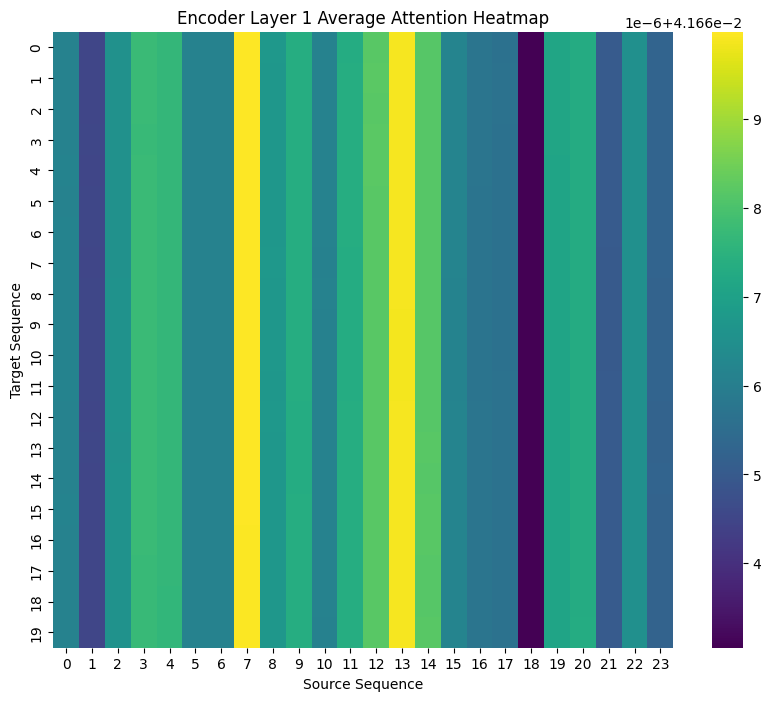

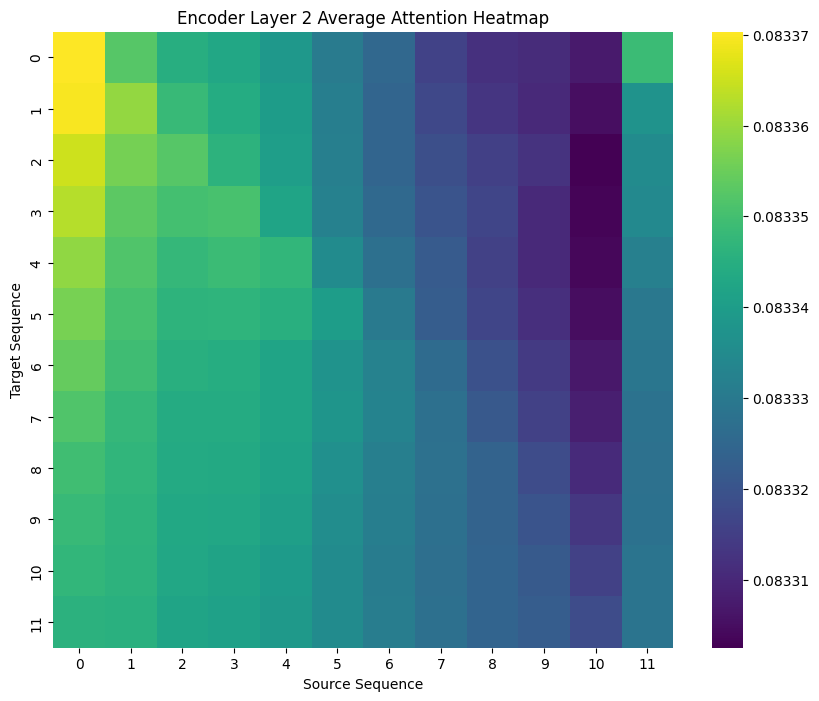

In [45]:
for layer, attention_tensor in enumerate(encoder_attentions):
    # Reshape the tensor for easier visualization
    attention_array = attention_tensor.cpu().detach().numpy()  # Convert to numpy array
    
    # Take the mean along the specified dimensions
    attention_mean = attention_array.mean(axis=(0, 1))  # Take mean along num_heads and batch_size dimensions
    
    # Plotting the heatmap for the average attention weights
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_mean, cmap='viridis')
    plt.title(f'Encoder Layer {layer+1} Average Attention Heatmap')
    plt.xlabel('Source Sequence')
    plt.ylabel('Target Sequence')
    plt.savefig(f'Informer_Modified_{layer+1}.png')
    plt.show()

In [138]:
true_values = val[-len(all_predictions):]
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_values, all_predictions))
mae = mean_absolute_error(true_values, all_predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 6.042252238216245
Mean Absolute Error (MAE): 4.4919810431216245


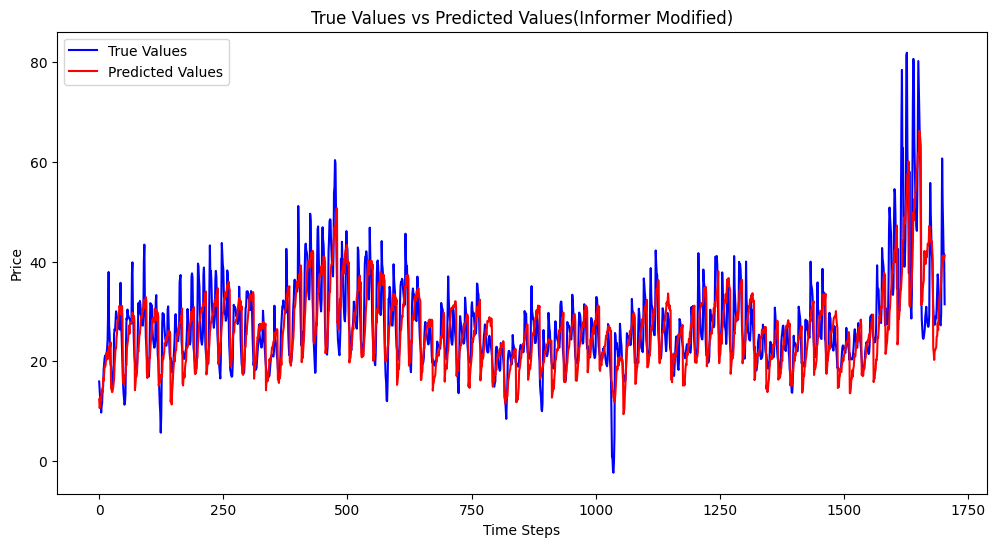

In [128]:
# Plot true values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(all_predictions, label='Predicted Values', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('True Values vs Predicted Values(Informer Modified)')
plt.legend()
plt.savefig('Informer_modified.png')
plt.show()
